In [117]:
import cv2
import robomaster
import time
from robomaster import robot
from robomaster import vision


class MarkerInfo:

    def __init__(self, x, y, w, h, info):
        self._x = x
        self._y = y
        self._w = w
        self._h = h
        self._info = info

    @property
    def pt1(self):
        return int((self._x - self._w / 2) * 1280), int((self._y - self._h / 2) * 720)

    @property
    def pt2(self):
        return int((self._x + self._w / 2) * 1280), int((self._y + self._h / 2) * 720)

    @property
    def center(self):
        return int(self._x * 1280), int(self._y * 720)

    @property
    def text(self):
        return self._info


markers = []
new_markers=False
no_target=0
def on_detect_marker(marker_info):
    global markers,new_markers,no_target
    number = len(marker_info)
    markers.clear()
    for i in range(0, number):
        x, y, w, h, info = marker_info[i]
        markers.append(MarkerInfo(x, y, w, h, info))
        print("marker:{0} x:{1}, y:{2}, w:{3}, h:{4}".format(info, x, y, w, h))
        new_markers=True
    #判断初始化PID控制的条件
    if len(markers)==0:
        no_target+=1
    else:
        no_target=0
    if no_target>=5:
        pid_init()

In [155]:
sum_err_x=0
last_err_x=0
kp = 200
ki = 100
kd = 150
err_list=[]
sumerr_list=[]
derr_list=[]
def pid_init():
    global sum_err_x,last_err_x,err_list
    sum_err_x=0
    last_err_x=0
    err_list.clear()
    sumerr_list.clear()
    derr_list.clear()
    
pid_finish=0
def gimbal_move(marker_detected):
    global sum_err_x,last_err_x,kp,ki,kd,err_list,pid_finish
    marker_x = marker_detected._x
    err_x = marker_x - 0.5
    sum_err_x+=err_x
    #print("marker_x={0}, p={1},i={2},d={3}".format(marker_x, err_x,sum_err_x,err_x-last_err_x))
    x_speed=kp * err_x+ki*sum_err_x+kd*(err_x-last_err_x)
    err_list.append(err_x)
    sumerr_list.append(sum_err_x)
    derr_list.append(err_x-last_err_x)
    last_err_x=err_x
    ep_gimbal.drive_speed(0, x_speed)
    time.sleep(0.1)
    ep_gimbal.drive_speed(0, 0)
    #判断结束PID控制的条件
    if abs(err_x)<0.001:
        pid_finish+=1
    else:
        pid_finish=0


In [156]:
ep_robot = robot.Robot()
ep_robot.initialize(conn_type="sta")

ep_vision = ep_robot.vision
ep_camera = ep_robot.camera
ep_gimbal = ep_robot.gimbal

ep_gimbal.moveto(pitch=0,yaw=20).wait_for_completed()

ep_camera.start_video_stream(display=False)
result = ep_vision.sub_detect_info(name="marker", callback=on_detect_marker)
for i in range(0, 500):
    img = ep_camera.read_cv2_image(strategy="newest", timeout=0.5)
    if new_markers:
        new_markers=False
        for j in range(0, len(markers)):
            cv2.rectangle(img, markers[j].pt1, markers[j].pt2, (255, 255, 255))
            cv2.putText(img, markers[j].text, markers[j].center, cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 255, 255), 3)
            if markers[j].text=='1' :
                gimbal_move(markers[j])
        if pid_finish>=5:
            break;            
    cv2.imshow("Markers", img)
    cv2.waitKey(1)
cv2.destroyAllWindows()

result = ep_vision.unsub_detect_info(name="marker")
cv2.destroyAllWindows()
ep_camera.stop_video_stream()
ep_robot.close()

marker:1 x:0.1, y:0.54028, w:0.12188, h:0.175
marker:1 x:0.1, y:0.54028, w:0.12188, h:0.175
marker:1 x:0.1, y:0.54167, w:0.12188, h:0.17778
marker:1 x:0.1, y:0.54028, w:0.12188, h:0.175
marker:1 x:0.1, y:0.54167, w:0.12188, h:0.17778
marker:1 x:0.1, y:0.54028, w:0.12188, h:0.175
marker:1 x:0.10078, y:0.54028, w:0.12031, h:0.175
marker:1 x:0.48672, y:0.56389, w:0.08281, h:0.13889
marker:1 x:0.47188, y:0.5625, w:0.08125, h:0.13611
marker:1 x:0.47344, y:0.56111, w:0.08125, h:0.13889
marker:1 x:0.47344, y:0.5625, w:0.08125, h:0.14167
marker:1 x:0.47656, y:0.5625, w:0.08125, h:0.13611
marker:1 x:0.47813, y:0.56111, w:0.08125, h:0.13889
marker:1 x:0.48359, y:0.56111, w:0.07969, h:0.13889
marker:1 x:0.48672, y:0.56111, w:0.07969, h:0.13889
marker:1 x:0.49062, y:0.56111, w:0.08125, h:0.13889
marker:1 x:0.49531, y:0.56111, w:0.08125, h:0.13889
marker:1 x:0.49844, y:0.56111, w:0.08125, h:0.13889
marker:1 x:0.50391, y:0.55833, w:0.07969, h:0.13889
marker:1 x:0.50703, y:0.55833, w:0.07969, h:0.138

marker:1 x:0.50156, y:0.56111, w:0.08125, h:0.13889
marker:1 x:0.50156, y:0.56111, w:0.08125, h:0.13889
marker:1 x:0.50156, y:0.56111, w:0.08125, h:0.13889
marker:1 x:0.50156, y:0.56111, w:0.08125, h:0.13889
marker:1 x:0.50156, y:0.56111, w:0.08125, h:0.13889
marker:1 x:0.50078, y:0.56111, w:0.07969, h:0.13889
marker:1 x:0.50078, y:0.56111, w:0.07969, h:0.13889
marker:1 x:0.50078, y:0.56111, w:0.07969, h:0.13889
marker:1 x:0.5, y:0.56111, w:0.08125, h:0.13889
marker:1 x:0.5, y:0.56111, w:0.08125, h:0.13889
marker:1 x:0.5, y:0.56111, w:0.08125, h:0.13889
marker:1 x:0.5, y:0.56111, w:0.08125, h:0.13889
marker:1 x:0.5, y:0.56111, w:0.08125, h:0.13889
marker:1 x:0.49922, y:0.56111, w:0.07969, h:0.13889
marker:1 x:0.49922, y:0.56111, w:0.07969, h:0.13889
marker:1 x:0.49922, y:0.56111, w:0.07969, h:0.13889
marker:1 x:0.49844, y:0.56111, w:0.08125, h:0.13889
marker:1 x:0.49844, y:0.56111, w:0.08125, h:0.13889
marker:1 x:0.49844, y:0.56111, w:0.08125, h:0.13889
marker:1 x:0.49844, y:0.56111, w

2021-10-31 15:01:16,863 ERROR client.py:163 Client: send_sync_msg wait msg receiver:0900, cmdset:0x3f, cmdid:0xd1 timeout!


p=200,i=100,d=150


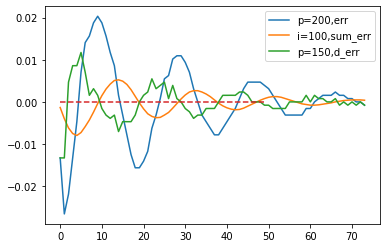

In [157]:
import matplotlib.pyplot as plt
import numpy as np
#notebook指令，让matplotlib可以在notebook中显示绘图
%matplotlib inline 
zeros=[0]*50
print("p=%d,i=%d,d=%d"%(kp,ki,kd))
dis_sumerr_list=(np.array(sumerr_list)/10).tolist()
plt.plot(err_list,label='p=%d,err'%(kp))
plt.plot(dis_sumerr_list,label='i=%d,sum_err'%(ki))
plt.plot(derr_list,label='p=%d,d_err'%(kd))
plt.plot(zeros,'--')
plt.legend()#有这句才能显示label